# 3-1-2: Reading text into dataframes

## Download text data and install packages

In [1]:
!rm -rf *.zip osm-cca-* 2>/dev/null
!git clone https://github.com/cca-cce/osm-cca-nlp.git

Cloning into 'osm-cca-nlp'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 89 (delta 24), reused 83 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 17.05 MiB | 20.66 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [2]:
!pip install -q pdfminer.six

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 24.8 MB/s eta 0:00:00


## Convert PDF to plain text

In [3]:
import os
from pdfminer.high_level import extract_text

# Directories containing the PDFs
directories = ['organization1', 'organization2']
directories = ['/content/osm-cca-nlp/res/pdf/preem', '/content/osm-cca-nlp/res/pdf/vattenfall']

for directory in directories:
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.pdf'):
                pdf_path = os.path.join(root, file)
                text_path = os.path.splitext(pdf_path)[0] + '.txt'

                try:
                    text = extract_text(pdf_path)
                    with open(text_path, 'w', encoding='utf-8') as f:
                        f.write(text)
                    print(f"Converted {pdf_path} to {text_path}")
                except Exception as e:
                    print(f"Failed to convert {pdf_path}: {e}")


Converted /content/osm-cca-nlp/res/pdf/preem/carbon-capture-and-storage-preem.pdf to /content/osm-cca-nlp/res/pdf/preem/carbon-capture-and-storage-preem.txt


Converted /content/osm-cca-nlp/res/pdf/preem/production-of-renewable-diesel-synsat-project-preem.pdf to /content/osm-cca-nlp/res/pdf/preem/production-of-renewable-diesel-synsat-project-preem.txt


Converted /content/osm-cca-nlp/res/pdf/preem/towards-a-climate-neutral-value-chain.pdf to /content/osm-cca-nlp/res/pdf/preem/towards-a-climate-neutral-value-chain.txt


Converted /content/osm-cca-nlp/res/pdf/preem/raw-materials-sustainability-preem.pdf to /content/osm-cca-nlp/res/pdf/preem/raw-materials-sustainability-preem.txt


Converted /content/osm-cca-nlp/res/pdf/preem/hvo-100-and-saf-sustainable-aviation-fuels-icr-project-preem.pdf to /content/osm-cca-nlp/res/pdf/preem/hvo-100-and-saf-sustainable-aviation-fuels-icr-project-preem.txt


Converted /content/osm-cca-nlp/res/pdf/vattenfall/shifting-the-climate-narrative-vattenfall.pdf to /content/osm-cca-nlp/res/pdf/vattenfall/shifting-the-climate-narrative-vattenfall.txt


Converted /content/osm-cca-nlp/res/pdf/vattenfall/fossil-free-fertilisers-a-key-to-cutting-carbon-emissions-vattenfall.pdf to /content/osm-cca-nlp/res/pdf/vattenfall/fossil-free-fertilisers-a-key-to-cutting-carbon-emissions-vattenfall.txt


Converted /content/osm-cca-nlp/res/pdf/vattenfall/vattenfall-expands-circular-targes-on-wind-turbine-components-vattenfall.pdf to /content/osm-cca-nlp/res/pdf/vattenfall/vattenfall-expands-circular-targes-on-wind-turbine-components-vattenfall.txt


Converted /content/osm-cca-nlp/res/pdf/vattenfall/un-s-sustainable-development-goals-vattenfall.pdf to /content/osm-cca-nlp/res/pdf/vattenfall/un-s-sustainable-development-goals-vattenfall.txt


## Read plain text to Pandas Dataframe

In [4]:
import os
import pandas as pd
import re
import string

# Directories containing the text files
directories = ['organization1', 'organization2']
directories = ['/content/osm-cca-nlp/res/pdf/preem', '/content/osm-cca-nlp/res/pdf/vattenfall']

data = []
text_index = 1

# Allowed characters: alphabetic, punctuation, and whitespace
allowed_chars = set(string.ascii_letters + string.punctuation + string.whitespace)

for directory in directories:
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.txt'):
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(root)

                with open(file_path, 'r', encoding='utf-8') as f:
                    raw_text = f.read()

                # Keep only allowed characters
                clean_text = ''.join(c for c in raw_text if c in allowed_chars)

                # Replace sequences of whitespace with a single space
                clean_text = re.sub(r'\s+', ' ', clean_text)

                # Trim leading and trailing whitespace
                clean_text = clean_text.strip()

                data.append({
                    'text_index': text_index,
                    'file_path': file_path,
                    'folder_name': folder_name,
                    'raw_text': raw_text,
                    'clean_text': clean_text
                })

                text_index += 1

# Create DataFrame
df_texts = pd.DataFrame(data, columns=['text_index', 'file_path', 'folder_name', 'raw_text', 'clean_text'])

# Save DataFrame to TSV file
df_texts.to_csv('df_texts.tsv', sep='\t', index=False)

# View text dataframe
df_texts.head()

,text_index,file_path,folder_name,raw_text,clean_text
0,1,/content/osm-cca-nlp/res/pdf/preem/hvo-100-and...,preem,HVO-100 and SAF (Sustainable Aviation Fuels) |...,HVO- and SAF (Sustainable Aviation Fuels) | IC...
1,2,/content/osm-cca-nlp/res/pdf/preem/production-...,preem,Production of renewable diesel | Synsat projec...,Production of renewable diesel | Synsat projec...
2,3,/content/osm-cca-nlp/res/pdf/preem/carbon-capt...,preem,Carbon Capture and Storage | Preem\n\nhttps://...,Carbon Capture and Storage | Preem https://www...
3,4,/content/osm-cca-nlp/res/pdf/preem/towards-a-c...,preem,Towards a climate-neutral value chain\n\nhttps...,Towards a climate-neutral value chain https://...
4,5,/content/osm-cca-nlp/res/pdf/preem/raw-materia...,preem,Raw Materials | Sustainability | Preem\n\nhttp...,Raw Materials | Sustainability | Preem https:/...


# 3-1-3: Descriptive text analysis

## Count texts, words, and characters

In [5]:
# Add new columns for text statistics
df_texts['text_name'] = df_texts['file_path'].apply(os.path.basename)

# Word and character counts
df_texts['word_count'] = df_texts['clean_text'].apply(lambda x: len(x.split()))
df_texts['char_count'] = df_texts['clean_text'].apply(len)

# Mean characters per word (avoid division by zero)
df_texts['mean_chars_per_word'] = df_texts.apply(
    lambda row: row['char_count'] / row['word_count'] if row['word_count'] > 0 else 0,
    axis=1
)

# Select relevant columns for descriptive output
df_stats = df_texts[['text_name', 'word_count', 'char_count', 'mean_chars_per_word']]

# View the stats table
df_stats

# Optional: summary of word and character stats
#summary = df_stats[['word_count', 'char_count', 'mean_chars_per_word']].describe()
#print("\nDescriptive summary:\n", summary)


,text_name,word_count,char_count,mean_chars_per_word
0,hvo-100-and-saf-sustainable-aviation-fuels-icr...,604,4018,6.652318
1,production-of-renewable-diesel-synsat-project-...,902,5808,6.439024
2,carbon-capture-and-storage-preem.txt,607,4012,6.609555
3,towards-a-climate-neutral-value-chain.txt,509,3429,6.736739
4,raw-materials-sustainability-preem.txt,332,2207,6.647590
5,shifting-the-climate-narrative-vattenfall.txt,1421,9459,6.656580
6,fossil-free-fertilisers-a-key-to-cutting-carbo...,988,6623,6.703441
7,un-s-sustainable-development-goals-vattenfall.txt,1247,9139,7.328789
8,vattenfall-expands-circular-targes-on-wind-tur...,744,5340,7.177419


## Download pre-trained English language model

In [6]:
# for more languages, check https://spacy.io/models
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 88.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 3-2-2: Inferential text analysis, tokenization

## Split text into sentences

In [7]:
import pandas as pd
import re
import spacy

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

data = []

for idx, row in df_texts.iterrows():
    text_index = row['text_index']
    folder_name = row['folder_name']
    clean_text = row['clean_text']

    # Process the clean text to identify sentences
    doc = nlp(clean_text)

    sentence_index = 1
    for sent in doc.sents:
        sentence_text = sent.text

        # Squeeze, trim, and convert sequences of whitespace to single spaces
        sentence_text = re.sub(r'\s+', ' ', sentence_text).strip()

        # Check if the sentence exceeds five words
        if len(sentence_text.split()) > 5:
            data.append({
                'text_index': text_index,
                'folder_name': folder_name,
                'sentence_index': sentence_index,
                'sentence_text': sentence_text
            })
            sentence_index += 1

# Create the DataFrame
df_sentences = pd.DataFrame(data, columns=['text_index', 'folder_name', 'sentence_index', 'sentence_text'])

# Save the DataFrame to a TSV file
df_sentences.to_csv('df_sentences.tsv', sep='\t', index=False)

# View sentence dataframe
df_sentences.head()

,text_index,folder_name,sentence_index,sentence_text
0,1,preem,1,HVO- and SAF (Sustainable Aviation Fuels) | IC...
1,1,preem,2,About us / Projects / ICR Project I C R P ROJ ...
2,1,preem,3,"Starting in , we are rebuilding the so-called ..."
3,1,preem,4,The plant is currently being used for the prod...
4,1,preem,5,"After the conversion, the plant will produce r..."


## Split sentences into tokens

In [8]:
import pandas as pd
import spacy
from nltk.corpus import stopwords
import nltk

# Download stopwords
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Get NLTK English stopwords
stop_words = set(stopwords.words('english'))

# Step 1: Extract base token data (text + lemma)
data = []

for idx, row in df_sentences.iterrows():
    text_index = row['text_index']
    folder_name = row['folder_name']
    sentence_index = row['sentence_index']
    sentence_text = row['sentence_text']

    doc = nlp(sentence_text)

    token_index = 1
    for token in doc:
        if token.is_alpha and token.text.lower() not in stop_words:
            data.append({
                'text_index': text_index,
                'folder_name': folder_name,
                'sentence_index': sentence_index,
                'token_index': token_index,
                'token_text': token.text,
                'token_lemma': token.lemma_
            })
            token_index += 1

# Create base token dataframe
df_tokens = pd.DataFrame(data)

# Preview
df_tokens.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text_index,folder_name,sentence_index,token_index,token_text,token_lemma
0,1,preem,1,1,SAF,SAF
1,1,preem,1,2,Sustainable,sustainable
2,1,preem,1,3,Aviation,Aviation
3,1,preem,1,4,Fuels,Fuels
4,1,preem,1,5,ICR,ICR


# 3-2-3: Inferential text analysis, POS and NER

## Part of speech analysis (POS)

In [9]:
# Step 2: Add POS tags
pos_tags = []

for idx, row in df_sentences.iterrows():
    doc = nlp(row['sentence_text'])
    pos_tags.extend([
        token.pos_
        for token in doc
        if token.is_alpha and token.text.lower() not in stop_words
    ])

# Append POS column
df_tokens['token_pos'] = pos_tags

# Preview
df_tokens.head()


,text_index,folder_name,sentence_index,token_index,token_text,token_lemma,token_pos
0,1,preem,1,1,SAF,SAF,PROPN
1,1,preem,1,2,Sustainable,sustainable,ADJ
2,1,preem,1,3,Aviation,Aviation,PROPN
3,1,preem,1,4,Fuels,Fuels,PROPN
4,1,preem,1,5,ICR,ICR,PROPN


## Named entity recognition (NER)

In [10]:
# Step 3: Add entity types
entity_types = []

for idx, row in df_sentences.iterrows():
    doc = nlp(row['sentence_text'])
    entity_types.extend([
        token.ent_type_ if token.ent_type_ else 'O'
        for token in doc
        if token.is_alpha and token.text.lower() not in stop_words
    ])

# Append entity column
df_tokens['token_entity'] = entity_types

# Save full token dataframe
df_tokens.to_csv('df_tokens.tsv', sep='\t', index=False)

# Preview
df_tokens.head()


,text_index,folder_name,sentence_index,token_index,token_text,token_lemma,token_pos,token_entity
0,1,preem,1,1,SAF,SAF,PROPN,ORG
1,1,preem,1,2,Sustainable,sustainable,ADJ,O
2,1,preem,1,3,Aviation,Aviation,PROPN,O
3,1,preem,1,4,Fuels,Fuels,PROPN,O
4,1,preem,1,5,ICR,ICR,PROPN,ORG


# 3-3-2: Summarizing results of text analysis

## Summarize data (select, filter, aggregate)

In [11]:
import pandas as pd

# Define the POS tags we're interested in
pos_tags = ['NOUN', 'PROPN', 'VERB', 'ADJ']

# Filter df_tokens to include only the desired POS tags
filtered_df = df_tokens[df_tokens['token_pos'].isin(pos_tags)]

# Group by folder_name, token_pos, and token_lemma, and count occurrences
grouped = (
    filtered_df.groupby(['folder_name', 'token_pos', 'token_lemma'])
    .size()
    .reset_index(name='count')
)

# For each folder_name and token_pos, get the top 10 most frequent token_lemmas
df_tokens_frequency = (
    grouped.groupby(['folder_name', 'token_pos'])
    .apply(lambda x: x.nlargest(10, 'count'))
    .reset_index(drop=True)
)

# Optionally, sort the dataframe for clarity
df_tokens_frequency = df_tokens_frequency.sort_values(
    ['folder_name', 'token_pos', 'count'], ascending=[True, True, False]
)

# Save df_tokens_frequency to TSV file
df_tokens_frequency.to_csv('df_tokens_frequency.tsv', sep='\t', index=False)

# Display the result
df_tokens_frequency.head(20)


<ipython-input-11-8fc5767ce18b>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(10, 'count'))


,folder_name,token_pos,token_lemma,count
0,preem,ADJ,renewable,44
1,preem,ADJ,raw,18
2,preem,ADJ,sustainable,11
3,preem,ADJ,neutral,10
4,preem,ADJ,fossil,8
5,preem,ADJ,cubic,7
6,preem,ADJ,crude,6
7,preem,ADJ,large,6
8,preem,ADJ,easy,5
9,preem,ADJ,new,5


# 3-3-3: Visualizing results of text analysis

## Visualize results (stacked bar plot)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load or reuse the frequency data
# df_tokens_frequency = pd.read_csv('df_tokens_frequency.tsv', sep='\t')

# Increase default font size
plt.rcParams.update({'font.size': 24})

# Store unique folder names
folder_names = df_tokens_frequency['folder_name'].unique()


In [14]:
def plot_token_pos_frequencies(df, token_pos_label):
    df_tp = df[df['token_pos'] == token_pos_label]
    unique_tokens = sorted(df_tp['token_lemma'].unique())[:20]
    if len(unique_tokens) < 20:
        unique_tokens.extend([''] * (20 - len(unique_tokens)))

    plot_data = pd.DataFrame({'token_lemma': unique_tokens})

    for folder_name in folder_names:
        df_folder = df_tp[df_tp['folder_name'] == folder_name]
        token_counts = df_folder.set_index('token_lemma')['count']
        plot_data[folder_name] = plot_data['token_lemma'].map(token_counts).fillna(0)

    fig, ax = plt.subplots(figsize=(20, 10))
    ind = np.arange(len(unique_tokens))
    bottom = np.zeros(len(unique_tokens))
    colors = plt.cm.Set2.colors
    color_cycle = colors[:len(folder_names)]

    ax.yaxis.grid(True)

    for i, folder_name in enumerate(folder_names):
        counts = plot_data[folder_name].values
        bars = ax.bar(ind, counts, bottom=bottom, color=color_cycle[i], label=folder_name)
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    int(height),
                    ha='center',
                    va='center',
                    fontsize=16
                )
        bottom += counts

    ax.set_xticks(ind)
    ax.set_xticklabels(plot_data['token_lemma'], rotation=90)
    ax.set_title(f"Token Frequencies for {token_pos_label}", fontsize=28)
    ax.set_xlabel('Token Lemma', fontsize=24)
    ax.set_ylabel('Frequency', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(title='Folder Name', fontsize=20, title_fontsize=22)
    plt.tight_layout()
    plt.savefig(f"df_tokens_frequency_{token_pos_label}.png")
    plt.show()


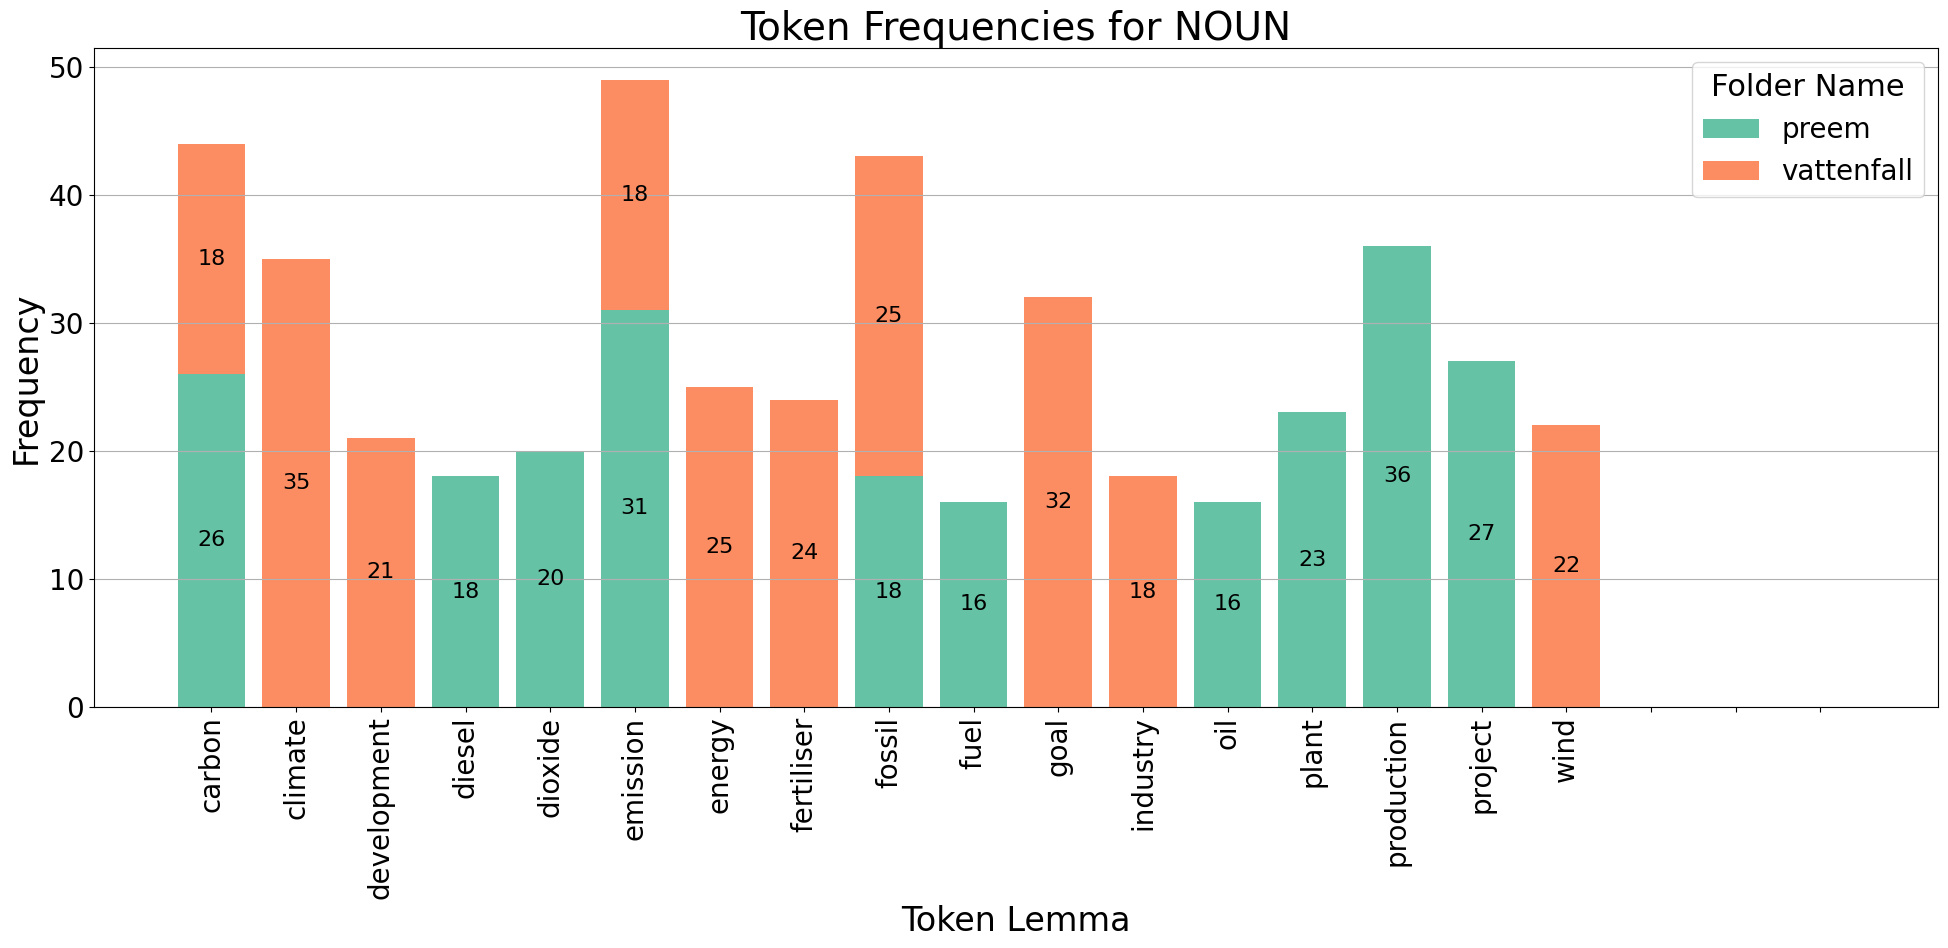

In [15]:
plot_token_pos_frequencies(df_tokens_frequency, "NOUN")


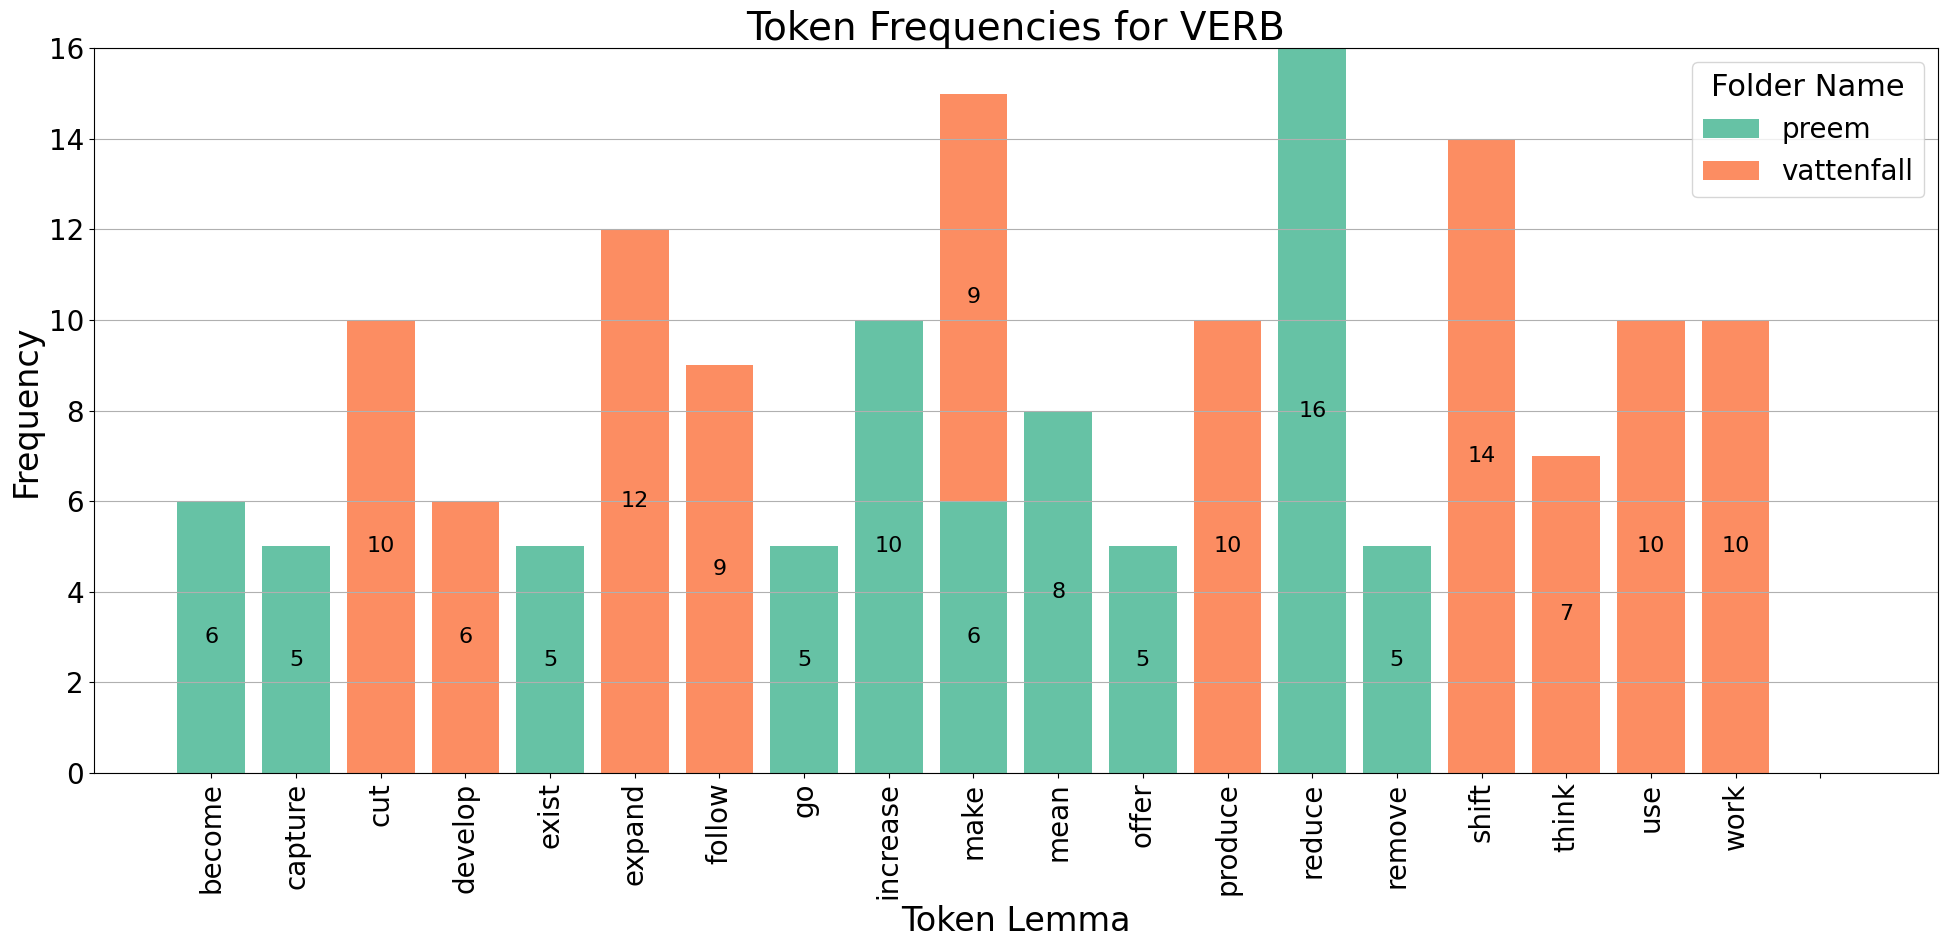

In [16]:
plot_token_pos_frequencies(df_tokens_frequency, "VERB")


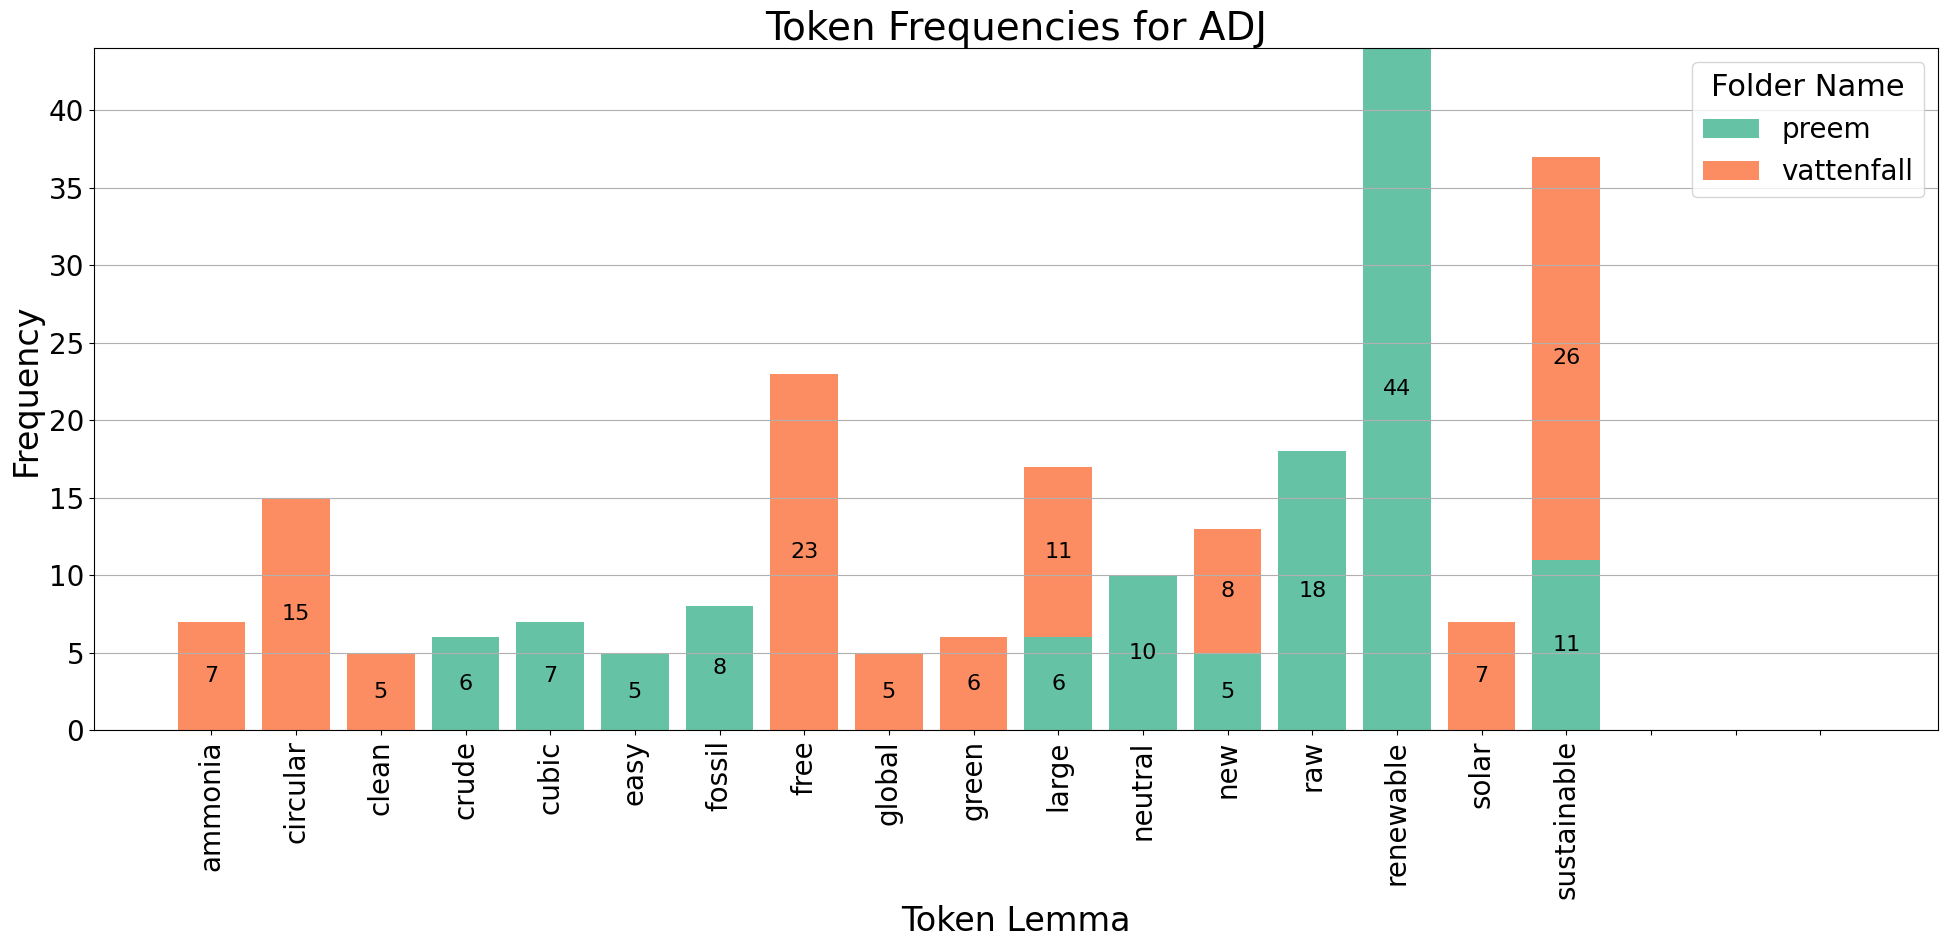

In [17]:
plot_token_pos_frequencies(df_tokens_frequency, "ADJ")


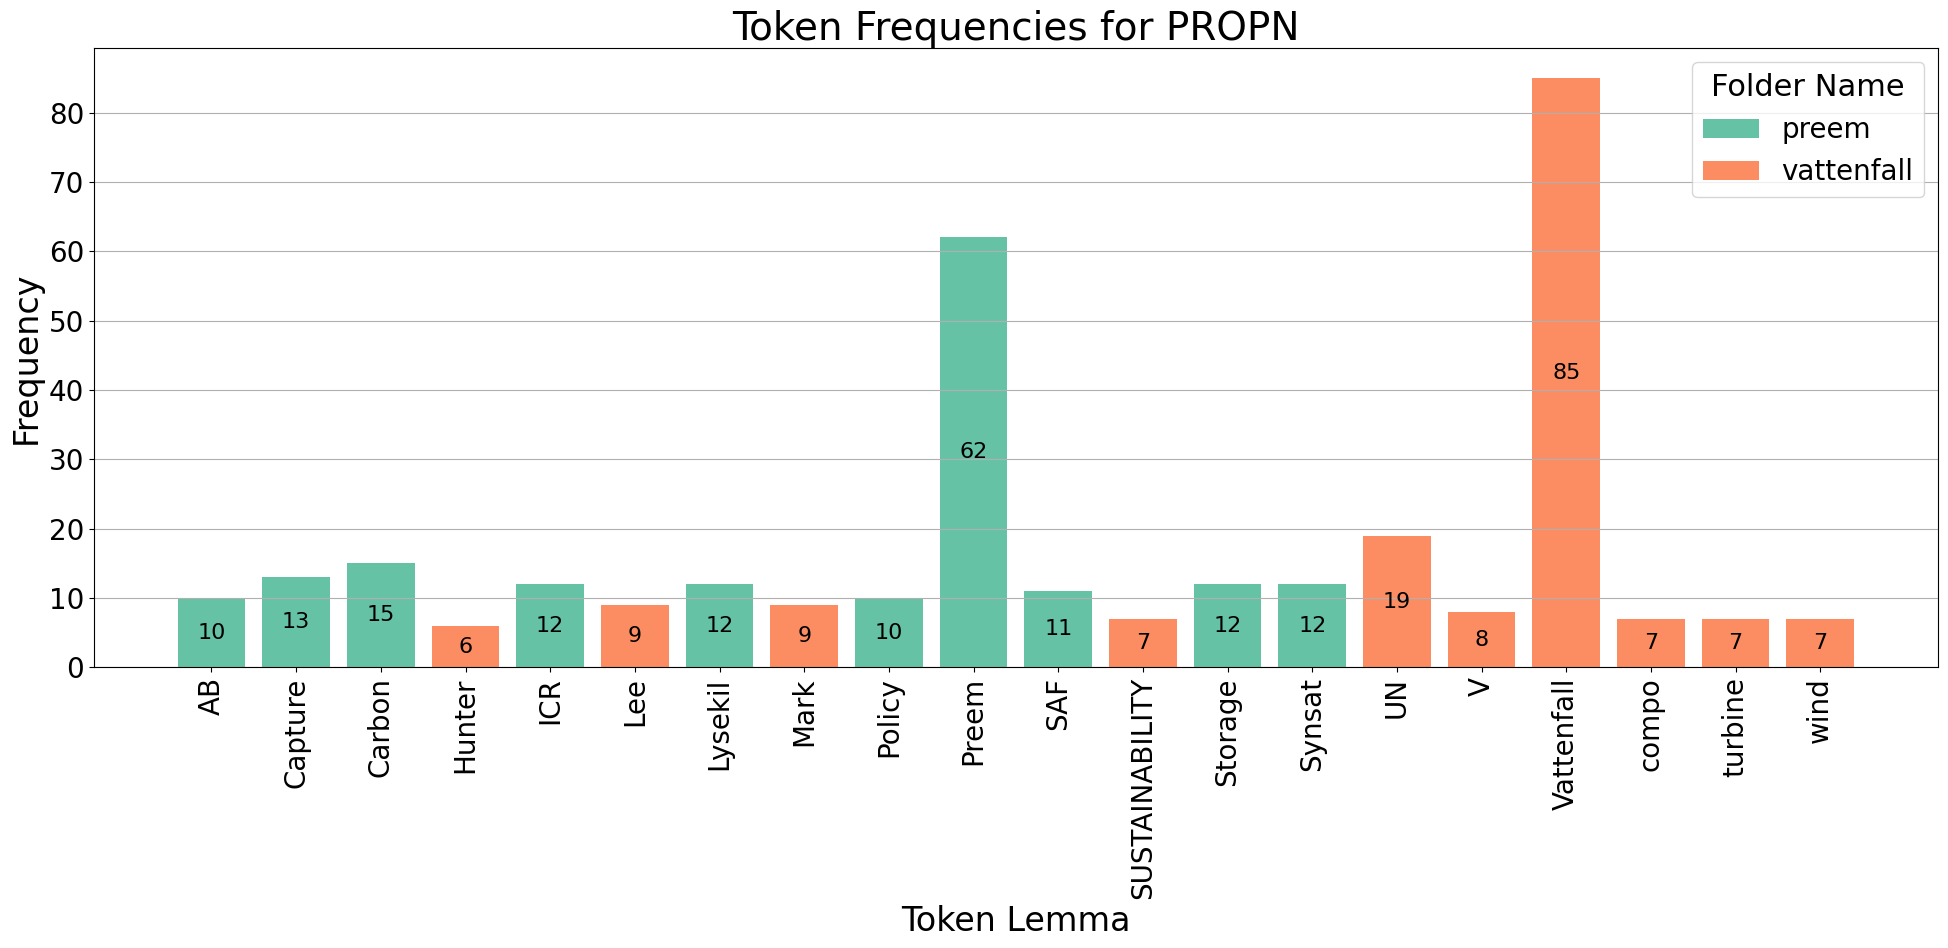

In [20]:
plot_token_pos_frequencies(df_tokens_frequency, "PROPN")
